<a href="https://colab.research.google.com/github/OWL-408/CIT2024/blob/main/%E3%83%87%E3%83%BC%E3%82%BF%E6%8B%A1%E5%BC%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


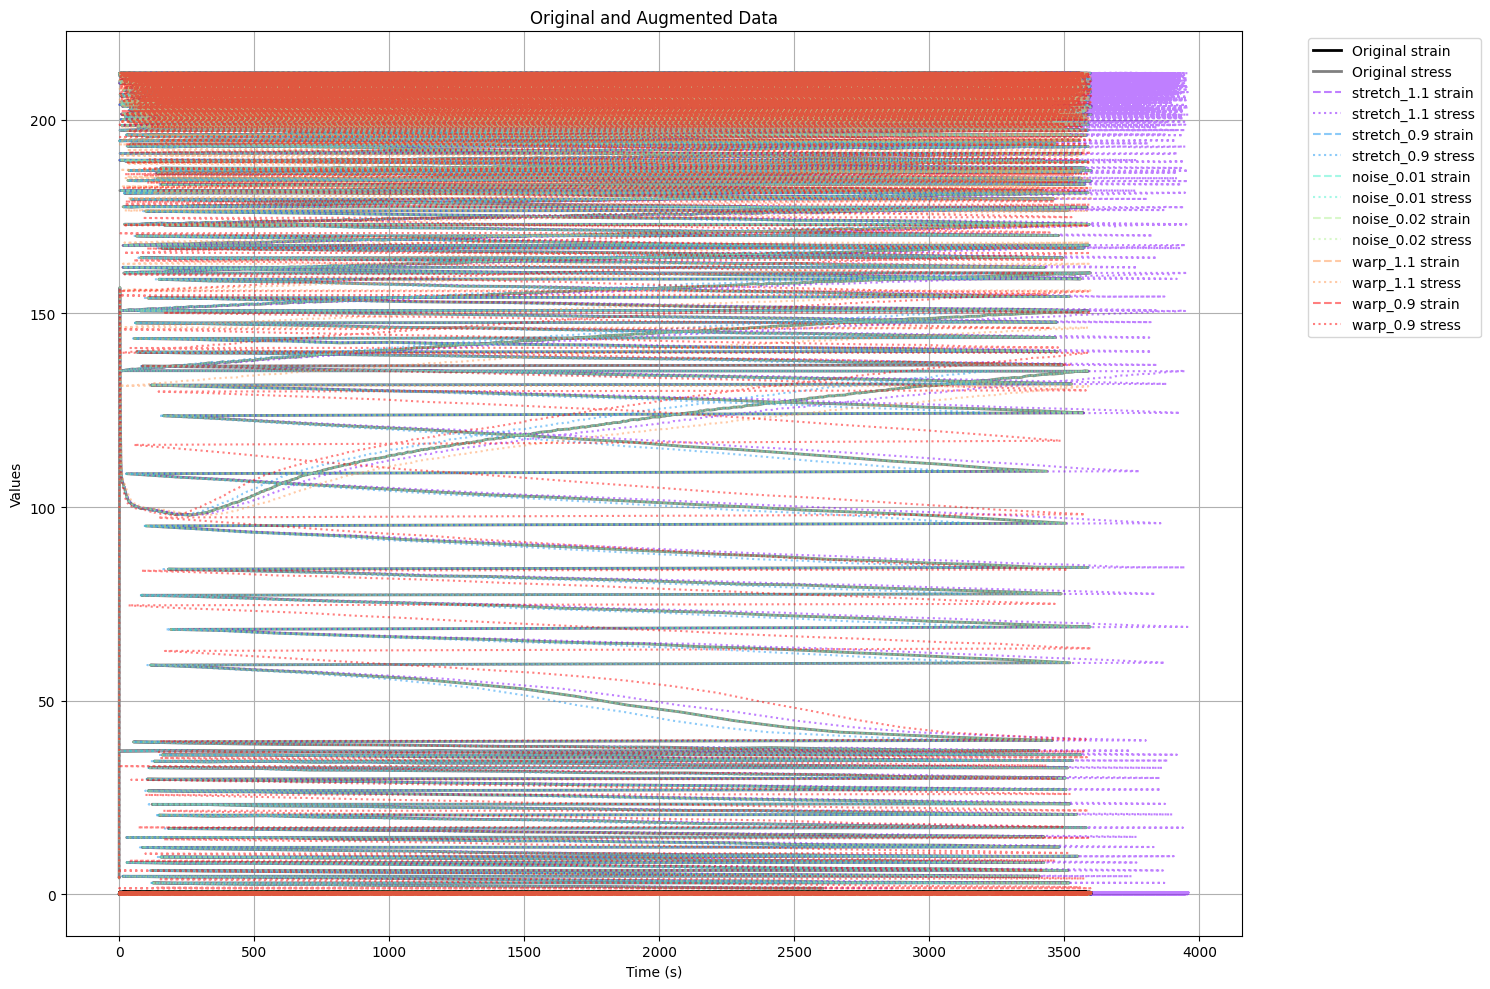


生成されたデータセット:
stretch_1.1: 7935行のデータを生成
stretch_0.9: 7935行のデータを生成
noise_0.01: 7935行のデータを生成
noise_0.02: 7935行のデータを生成
warp_1.1: 7935行のデータを生成
warp_0.9: 7935行のデータを生成


In [ ]:
# 必要なライブラリのインポート
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Googleドライブをマウント
drive.mount('/content/drive', force_remount=True)

# 時間文字列を秒に変換する関数
def convert_time_to_seconds(time_str):
    try:
        minutes, seconds = time_str.split(':')
        total_seconds = float(minutes) * 60 + float(seconds)
        return total_seconds
    except:
        return np.nan

# データの読み込みと前処理
data_path = '/content/drive/MyDrive/Data_Augmentation/F.csv'
data = pd.read_csv(data_path)

# 時間データの変換
data['time'] = data['time'].apply(convert_time_to_seconds)
data['Nominal strain'] = pd.to_numeric(data['Nominal strain'], errors='coerce')
data['Nominal stress'] = pd.to_numeric(data['Nominal stress'], errors='coerce')
data = data.dropna()

# データ拡張関数
def time_stretch(data, factor):
    stretched_data = data.copy()
    stretched_data['time'] = data['time'] * factor
    return stretched_data

def add_noise(data, noise_level):
    noisy_data = data.copy()
    noisy_data['Nominal strain'] = data['Nominal strain'] + np.random.normal(0, noise_level, len(data))
    noisy_data['Nominal stress'] = data['Nominal stress'] + np.random.normal(0, noise_level, len(data))
    return noisy_data

def frequency_warp(data, warp_factor):
    warped_data = data.copy()
    time_max = data['time'].max()
    new_time = np.linspace(0, time_max, len(data))
    warped_time = new_time * warp_factor

    warped_data['Nominal strain'] = np.interp(new_time, warped_time, data['Nominal strain'])
    warped_data['Nominal stress'] = np.interp(new_time, warped_time, data['Nominal stress'])
    return warped_data

# 出力ディレクトリの作成
output_dir = '/content/drive/MyDrive/Extended_Data/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# データ拡張の実行
augmented_data_list = []
augmented_methods = [
    ('stretch_1.1', time_stretch(data, 1.1)),
    ('stretch_0.9', time_stretch(data, 0.9)),
    ('noise_0.01', add_noise(data, 0.01)),
    ('noise_0.02', add_noise(data, 0.02)),
    ('warp_1.1', frequency_warp(data, 1.1)),
    ('warp_0.9', frequency_warp(data, 0.9))
]

# 拡張データの保存
for name, aug_data in augmented_methods:
    augmented_data_list.append((name, aug_data))
    output_file_path = os.path.join(output_dir, f'{name}.csv')
    aug_data.to_csv(output_file_path, index=False)

# 結果のプロット
plt.figure(figsize=(15, 10))

# 元データのプロット
plt.plot(data['time'], data['Nominal strain'],
         label='Original strain', color='black', linewidth=2)
plt.plot(data['time'], data['Nominal stress'],
         label='Original stress', color='gray', linewidth=2)

# 拡張データのプロット
colors = plt.cm.rainbow(np.linspace(0, 1, len(augmented_data_list)))
for (name, aug_data), color in zip(augmented_data_list, colors):
    plt.plot(aug_data['time'], aug_data['Nominal strain'],
            label=f'{name} strain', linestyle='--', color=color, alpha=0.5)
    plt.plot(aug_data['time'], aug_data['Nominal stress'],
            label=f'{name} stress', linestyle=':', color=color, alpha=0.5)

plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.title('Original and Augmented Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 拡張データの情報を表示
print("\n生成されたデータセット:")
for name, aug_data in augmented_data_list:
    print(f"{name}: {len(aug_data)}行のデータを生成")

Mounted at /content/drive


<ipython-input-15-7c6d04eae015>:77: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  strain_noise = pd.Series(strain_noise).rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill')
<ipython-input-15-7c6d04eae015>:78: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stress_noise = pd.Series(stress_noise).rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill')


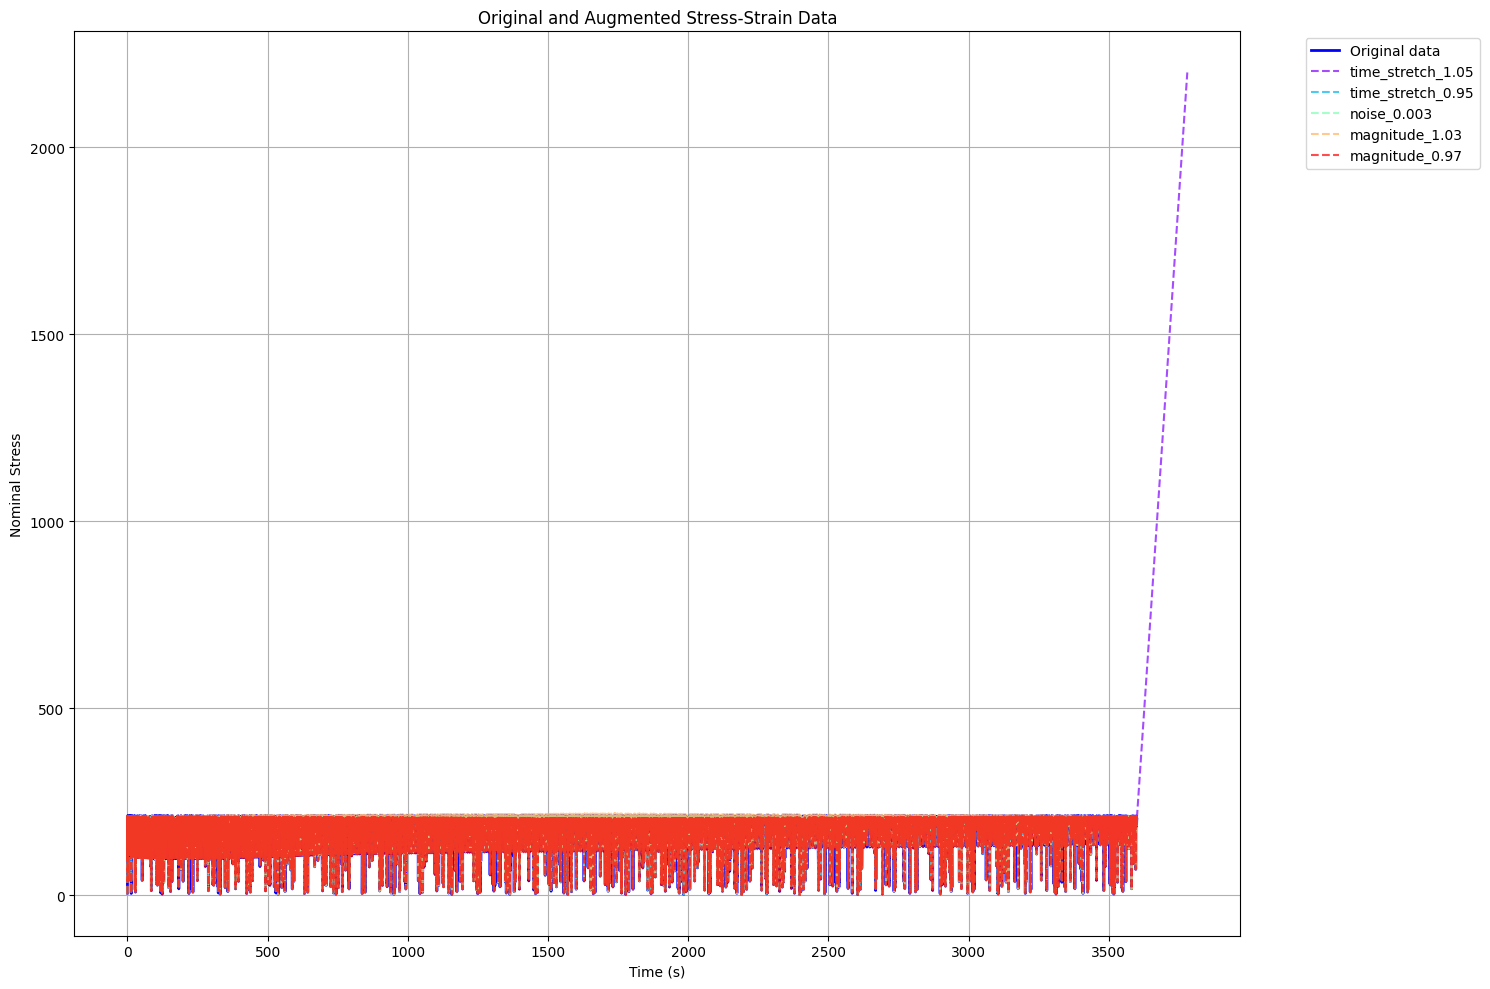


各データセットの基本統計量:

元データ:
       Nominal stress  Nominal strain
count     7935.000000     7935.000000
mean       181.870400        0.278636
std         45.688816        0.177493
min          1.596063       -0.000006
25%        172.263900        0.123292
50%        203.265500        0.262320
75%        210.062000        0.425757
max        212.215700        0.620464


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from google.colab import drive

# Googleドライブをマウント
drive.mount('/content/drive', force_remount=True)

def convert_time_to_seconds(time_str):
    """時間文字列を秒に変換"""
    try:
        minutes, seconds = time_str.split(':')
        total_seconds = float(minutes) * 60 + float(seconds)
        return total_seconds
    except:
        return np.nan

def preprocess_data(data_path):
    """データの読み込みと前処理"""
    data = pd.read_csv(data_path)

    # 時間データの変換
    data['time'] = data['time'].apply(convert_time_to_seconds)
    data['Nominal strain'] = pd.to_numeric(data['Nominal strain'], errors='coerce')
    data['Nominal stress'] = pd.to_numeric(data['Nominal stress'], errors='coerce')
    data = data.dropna()

    # 時間を0から始まるように調整
    data['time'] = data['time'] - data['time'].min()

    # インデックスを追加して重複を解消
    data['time'] = data['time'] + np.linspace(0, 0.0001, len(data))

    # データを時間でソート
    data = data.sort_values('time').reset_index(drop=True)

    return data

def time_stretch(data, factor):
    """時間軸の伸縮（補間を使用）"""
    stretched_data = data.copy()

    # オリジナルの時間範囲
    original_time = data['time'].values
    max_time = original_time.max()

    # 新しい時間軸を生成（均等な間隔で）
    new_time = np.linspace(0, max_time * factor, len(data))

    # 補間関数の作成
    strain_interp = interp1d(original_time, data['Nominal strain'].values, kind='linear', bounds_error=False, fill_value="extrapolate")
    stress_interp = interp1d(original_time, data['Nominal stress'].values, kind='linear', bounds_error=False, fill_value="extrapolate")

    # 新しい時間軸でデータを生成
    stretched_data['time'] = new_time
    stretched_data['Nominal strain'] = strain_interp(new_time)
    stretched_data['Nominal stress'] = stress_interp(new_time)

    return stretched_data

def add_noise(data, noise_level):
    """適応的なノイズの追加"""
    noisy_data = data.copy()

    # データの標準偏差に基づいてノイズレベルを調整
    strain_std = data['Nominal strain'].std()
    stress_std = data['Nominal stress'].std()

    # ノイズを追加（信号の強度に応じて調整）
    strain_noise = np.random.normal(0, strain_std * noise_level, len(data))
    stress_noise = np.random.normal(0, stress_std * noise_level, len(data))

    # 移動平均でノイズを滑らかに
    window = 5
    strain_noise = pd.Series(strain_noise).rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill')
    stress_noise = pd.Series(stress_noise).rolling(window=window, center=True).mean().fillna(method='bfill').fillna(method='ffill')

    noisy_data['Nominal strain'] = data['Nominal strain'] + strain_noise
    noisy_data['Nominal stress'] = data['Nominal stress'] + stress_noise

    return noisy_data

def magnitude_warp(data, warp_factor):
    """振幅の伸縮（なめらかな変化）"""
    warped_data = data.copy()

    # 正規化された位置に基づいて重み付けを行う
    normalized_pos = np.linspace(0, 1, len(data))
    weight = 1 + (warp_factor - 1) * (1 - np.abs(2 * normalized_pos - 1))

    warped_data['Nominal strain'] = data['Nominal strain'] * weight
    warped_data['Nominal stress'] = data['Nominal stress'] * weight
    return warped_data

# メインの処理
data_path = '/content/drive/MyDrive/Data_Augmentation/F.csv'
output_dir = '/content/drive/MyDrive/Extended_Data/'

# データの読み込みと前処理
data = preprocess_data(data_path)

# 出力ディレクトリの作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# データ拡張の実行
augmented_data_list = []
augmented_methods = [
    ('time_stretch_1.05', time_stretch(data, 1.05)),  # より控えめな伸縮
    ('time_stretch_0.95', time_stretch(data, 0.95)),
    ('noise_0.003', add_noise(data, 0.003)),          # より小さいノイズ
    ('magnitude_1.03', magnitude_warp(data, 1.03)),   # より控えめな振幅変化
    ('magnitude_0.97', magnitude_warp(data, 0.97))
]

# 拡張データの保存
for name, aug_data in augmented_methods:
    augmented_data_list.append((name, aug_data))
    output_file_path = os.path.join(output_dir, f'{name}.csv')
    aug_data.to_csv(output_file_path, index=False)

# 結果のプロット
plt.figure(figsize=(15, 10))

# 元データのプロット
plt.plot(data['time'], data['Nominal stress'],
         label='Original data', color='blue', linewidth=2)

# 拡張データのプロット
colors = plt.cm.rainbow(np.linspace(0, 1, len(augmented_data_list)))
for (name, aug_data), color in zip(augmented_data_list, colors):
    plt.plot(aug_data['time'], aug_data['Nominal stress'],
            label=f'{name}', linestyle='--', color=color, alpha=0.7)

plt.xlabel('Time (s)')
plt.ylabel('Nominal Stress')
plt.title('Original and Augmented Stress-Strain Data')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# データの統計情報を表示
print("\n各データセットの基本統計量:")
print("\n元データ:")
print(data[['Nominal stress', 'Nominal strain']].describe())

Mounted at /content/drive


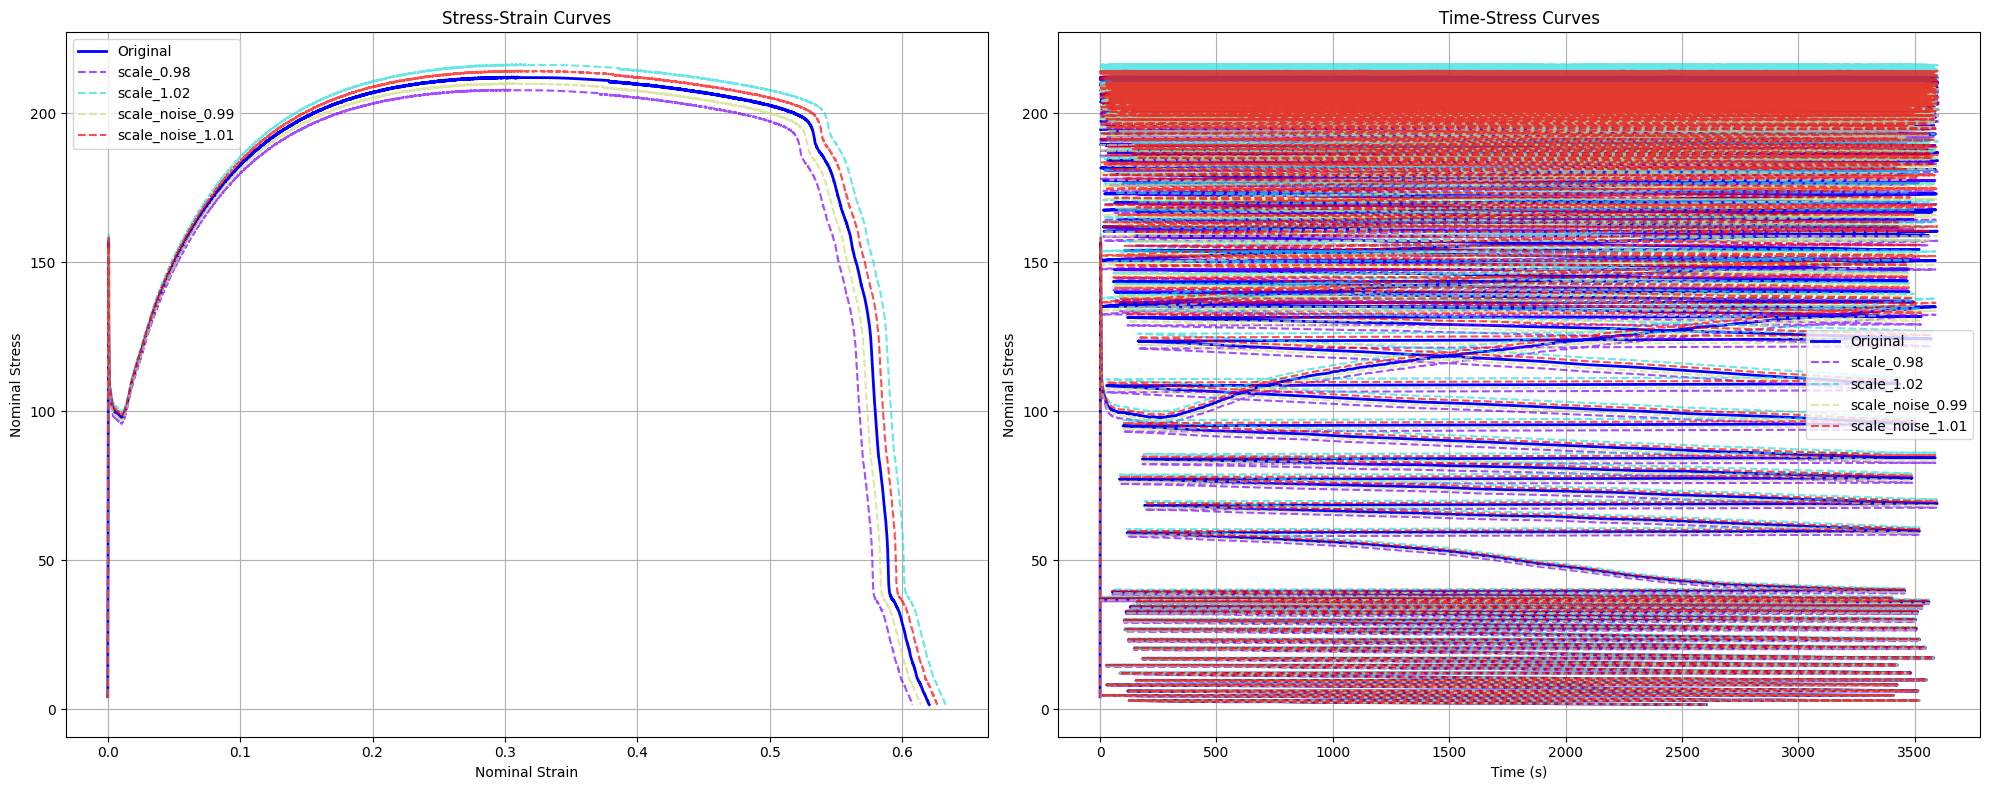


各データセットの基本統計量:

元データ:
       Nominal stress  Nominal strain
count     7935.000000     7935.000000
mean       181.870400        0.278636
std         45.688816        0.177493
min          1.596063       -0.000006
25%        172.263900        0.123292
50%        203.265500        0.262320
75%        210.062000        0.425757
max        212.215700        0.620464

scale_0.98:
       Nominal stress  Nominal strain
count     7935.000000     7935.000000
mean       178.232992        0.273064
std         44.775039        0.173943
min          1.564142       -0.000006
25%        168.818622        0.120826
50%        199.200190        0.257074
75%        205.860760        0.417242
max        207.971386        0.608055

scale_1.02:
       Nominal stress  Nominal strain
count     7935.000000     7935.000000
mean       185.507808        0.284209
std         46.602592        0.181043
min          1.627984       -0.000006
25%        175.709178        0.125758
50%        207.330810        0.267566
7

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from google.colab import drive

# Googleドライブをマウント
drive.mount('/content/drive', force_remount=True)

def convert_time_to_seconds(time_str):
    """時間文字列を秒に変換"""
    try:
        minutes, seconds = time_str.split(':')
        total_seconds = float(minutes) * 60 + float(seconds)
        return total_seconds
    except:
        return np.nan

def preprocess_data(data_path):
    """データの読み込みと前処理"""
    data = pd.read_csv(data_path)

    # 時間データの変換
    data['time'] = data['time'].apply(convert_time_to_seconds)
    data['Nominal strain'] = pd.to_numeric(data['Nominal strain'], errors='coerce')
    data['Nominal stress'] = pd.to_numeric(data['Nominal stress'], errors='coerce')
    data = data.dropna()

    # データをソート
    data = data.sort_values(['Nominal strain', 'Nominal stress']).reset_index(drop=True)

    return data

def augment_curve(data, scale_factor=1.0, noise_level=0.001):
    """応力-ひずみ曲線の特徴を保持しながらデータを拡張"""
    aug_data = data.copy()

    # 応力とひずみの関係を保持しながらスケーリング
    aug_data['Nominal strain'] = data['Nominal strain'] * scale_factor
    aug_data['Nominal stress'] = data['Nominal stress'] * scale_factor

    # 非常に小さいノイズを追加（オプション）
    if noise_level > 0:
        strain_noise = np.random.normal(0, noise_level * data['Nominal strain'].std(), len(data))
        stress_noise = np.random.normal(0, noise_level * data['Nominal stress'].std(), len(data))

        aug_data['Nominal strain'] += strain_noise
        aug_data['Nominal stress'] += stress_noise

    # 時間軸の調整（元データの時間範囲を保持）
    time_scale = 1.0  # 必要に応じて調整
    aug_data['time'] = data['time'] * time_scale

    return aug_data

def plot_results(original_data, augmented_datasets, save_path=None):
    """結果の可視化（応力-ひずみ曲線と時間-応力曲線）"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # 応力-ひずみ曲線
    ax1.plot(original_data['Nominal strain'], original_data['Nominal stress'],
             label='Original', color='blue', linewidth=2)

    # 時間-応力曲線
    ax2.plot(original_data['time'], original_data['Nominal stress'],
             label='Original', color='blue', linewidth=2)

    colors = plt.cm.rainbow(np.linspace(0, 1, len(augmented_datasets)))

    for (name, aug_data), color in zip(augmented_datasets, colors):
        # 応力-ひずみ曲線
        ax1.plot(aug_data['Nominal strain'], aug_data['Nominal stress'],
                label=name, linestyle='--', color=color, alpha=0.7)

        # 時間-応力曲線
        ax2.plot(aug_data['time'], aug_data['Nominal stress'],
                label=name, linestyle='--', color=color, alpha=0.7)

    ax1.set_xlabel('Nominal Strain')
    ax1.set_ylabel('Nominal Stress')
    ax1.set_title('Stress-Strain Curves')
    ax1.grid(True)
    ax1.legend()

    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Nominal Stress')
    ax2.set_title('Time-Stress Curves')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
    plt.show()

# メインの処理
data_path = '/content/drive/MyDrive/Data_Augmentation/F.csv'
output_dir = '/content/drive/MyDrive/Extended_Data/'

# データの読み込みと前処理
data = preprocess_data(data_path)

# 出力ディレクトリの作成
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# データ拡張の実行
augmented_data_list = []
augmentation_params = [
    ('scale_0.98', 0.98, 0.0),
    ('scale_1.02', 1.02, 0.0),
    ('scale_noise_0.99', 0.99, 0.0005),
    ('scale_noise_1.01', 1.01, 0.0005)
]

for name, scale, noise in augmentation_params:
    aug_data = augment_curve(data, scale_factor=scale, noise_level=noise)
    augmented_data_list.append((name, aug_data))

    # 拡張データの保存
    output_file_path = os.path.join(output_dir, f'{name}.csv')
    aug_data.to_csv(output_file_path, index=False)

# 結果のプロット
plot_results(data, augmented_data_list, os.path.join(output_dir, 'augmentation_results.png'))

# データの統計情報を表示
print("\n各データセットの基本統計量:")
print("\n元データ:")
print(data[['Nominal stress', 'Nominal strain']].describe())

for name, aug_data in augmented_data_list:
    print(f"\n{name}:")
    print(aug_data[['Nominal stress', 'Nominal strain']].describe())

Mounted at /content/drive


ValueError: array of sample points is empty

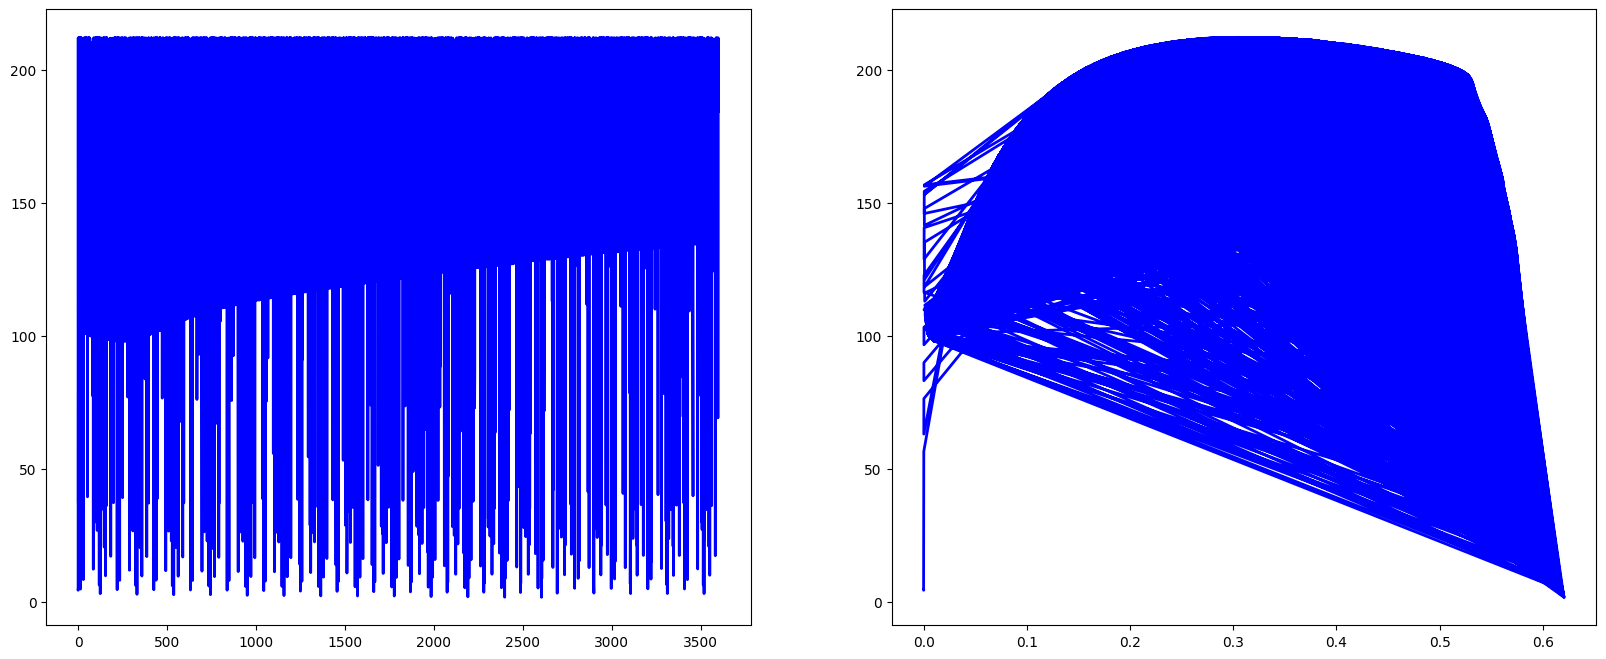

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Googleドライブをマウント
drive.mount('/content/drive', force_remount=True)

def convert_time_to_seconds(time_str):
    """時間文字列を秒に変換"""
    try:
        minutes, seconds = time_str.split(':')
        total_seconds = float(minutes) * 60 + float(seconds)
        return total_seconds
    except:
        return np.nan

def preprocess_data(data_path):
    """データの読み込みと前処理"""
    data = pd.read_csv(data_path)

    # 時間データの変換
    data['time'] = data['time'].apply(convert_time_to_seconds)
    data['Nominal strain'] = pd.to_numeric(data['Nominal strain'], errors='coerce')
    data['Nominal stress'] = pd.to_numeric(data['Nominal stress'], errors='coerce')
    data = data.dropna()

    # データをソート
    data = data.sort_values('time').reset_index(drop=True)

    return data

def create_comparison_plots(original_data, augmented_datasets):
    """応力vs時間とひずみの比較プロット"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # 共通の応力範囲を設定
    stress_min = original_data['Nominal stress'].min()
    stress_max = original_data['Nominal stress'].max()
    y_margin = (stress_max - stress_min) * 0.05  # 5%のマージン

    # 時間-応力プロット
    ax1.plot(original_data['time'], original_data['Nominal stress'],
             label='Original', color='blue', linewidth=2)

    # 応力-ひずみプロット
    ax2.plot(original_data['Nominal strain'], original_data['Nominal stress'],
             label='Original', color='blue', linewidth=2)

    # 拡張データのプロット
    colors = plt.cm.rainbow(np.linspace(0, 1, len(augmented_datasets)))
    for (name, aug_data), color in zip(augmented_datasets, colors):
        # 時間-応力プロット
        ax1.plot(aug_data['time'], aug_data['Nominal stress'],
                label=f'Augmented {name}', linestyle='--', color=color, alpha=0.7)

        # 応力-ひずみプロット
        ax2.plot(aug_data['Nominal strain'], aug_data['Nominal stress'],
                label=f'Augmented {name}', linestyle='--', color=color, alpha=0.7)

    # 時間-応力プロットの設定
    ax1.set_xlabel('Time (s)', fontsize=12)
    ax1.set_ylabel('Nominal Stress', fontsize=12)
    ax1.set_title('Stress vs Time', fontsize=14)
    ax1.grid(True)
    ax1.legend(fontsize=10)
    ax1.set_ylim(stress_min - y_margin, stress_max + y_margin)

    # 応力-ひずみプロットの設定
    ax2.set_xlabel('Nominal Strain', fontsize=12)
    ax2.set_ylabel('Nominal Stress', fontsize=12)
    ax2.set_title('Stress vs Strain', fontsize=14)
    ax2.grid(True)
    ax2.legend(fontsize=10)
    ax2.set_ylim(stress_min - y_margin, stress_max + y_margin)

    # レイアウトの調整
    plt.tight_layout()
    return fig

# メインの処理
data_path = '/content/drive/MyDrive/Data_Augmentation/F.csv'
output_dir = '/content/drive/MyDrive/Extended_Data/'

# データの読み込みと前処理
data = preprocess_data(data_path)

# 拡張データの読み込み
augmented_data_list = []
for filename in os.listdir(output_dir):
    if filename.endswith('.csv'):
        name = filename.replace('.csv', '')
        aug_data = pd.read_csv(os.path.join(output_dir, filename))
        aug_data['time'] = aug_data['time'].apply(convert_time_to_seconds)
        augmented_data_list.append((name, aug_data))

# プロットの作成と保存
fig = create_comparison_plots(data, augmented_data_list)
plt.savefig(os.path.join(output_dir, 'comparison_plots.png'), bbox_inches='tight', dpi=300)
plt.show()

# データの統計情報を表示
print("\n各データセットの応力の基本統計量:")
print("\n元データ:")
print(data['Nominal stress'].describe())

for name, aug_data in augmented_data_list:
    print(f"\n{name}:")
    print(aug_data['Nominal stress'].describe())

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Mount the Google Drive
drive.mount('/content/drive')

# Paths for input and output
data_path = '/content/drive/MyDrive/Excel_to_CSV/F.csv'
output_dir = '/content/drive/MyDrive/データ拡張/'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load the original CSV file
df = pd.read_csv(data_path)

# Convert time column to datetime format
df['time'] = pd.to_datetime(df['time'], format='%Y/%m/%d %H:%M:%S.%f')

# Functions for augmentations
def time_stretch(data, stretch_factor):
    """Stretch the time values by a factor."""
    data['time'] = data['time'] + pd.to_timedelta(data['time'].diff().fillna(pd.Timedelta(seconds=0)) * (stretch_factor - 1))
    return data

def add_noise(data, column, noise_level):
    """Add random noise to a column."""
    noise = np.random.normal(0, noise_level, size=len(data))
    data[column] = data[column] + noise
    return data

def frequency_warp(data, column, warp_factor):
    """Apply frequency warping."""
    freq_data = np.fft.rfft(data[column])
    warped_freq_data = np.interp(np.arange(0, len(freq_data), warp_factor), np.arange(0, len(freq_data)), freq_data)
    data[column] = np.fft.irfft(warped_freq_data, n=len(data[column]))
    return data

# Generate 9 augmented datasets
augmented_data = []
for i in range(9):
    aug_df = df.copy()

    if i < 2:
        # Apply time stretch to time and strain
        aug_df = time_stretch(aug_df, 1.05 if i == 0 else 0.95)
        aug_df = time_stretch(aug_df, 1.05 if i == 1 else 0.95)
    elif i < 4:
        # Add noise to time and stress
        aug_df = add_noise(aug_df, 'time', 0.01 if i == 2 else 0.02)
        aug_df = add_noise(aug_df, 'Nominal stress', 5 if i == 3 else 10)
    else:
        # Apply frequency warping to time, strain, and stress
        aug_df = frequency_warp(aug_df, 'time', 1.1 if i == 4 else 0.9)
        aug_df = frequency_warp(aug_df, 'Nominal strain', 1.1 if i == 5 else 0.9)
        aug_df = frequency_warp(aug_df, 'Nominal stress', 1.1 if i == 6 else 0.9)

    augmented_data.append(aug_df)
    aug_df.to_csv(f'{output_dir}/augmented_data_{i+1}.csv', index=False)

# Plot the original and augmented data
plt.figure(figsize=(14, 8))

# Original data
plt.plot(df['time'], df['Nominal stress'], label='Original', linewidth=2)

# Augmented data
for i, aug_df in enumerate(augmented_data):
    plt.plot(aug_df['time'], aug_df['Nominal stress'], label=f'Augmented {i+1}', linestyle='--')

# Customize the plot
plt.title('Comparison of Original and Augmented Data (Nominal Stress vs Time)')
plt.xlabel('Time')
plt.ylabel('Nominal Stress')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig(f'{output_dir}/comparison_stress_vs_time.png')

# Show the plot
plt.show()

# Plot stress vs strain
plt.figure(figsize=(14, 8))

# Original data
plt.plot(df['Nominal strain'], df['Nominal stress'], label='Original', linewidth=2)

# Augmented data
for i, aug_df in enumerate(augmented_data):
    plt.plot(aug_df['Nominal strain'], aug_df['Nominal stress'], label=f'Augmented {i+1}', linestyle='--')

# Customize the plot
plt.title('Comparison of Original and Augmented Data (Nominal Stress vs Strain)')
plt.xlabel('Nominal Strain')
plt.ylabel('Nominal Stress')
plt.legend()
plt.grid(True)

# Save the plot
plt.savefig(f'{output_dir}/comparison_stress_vs_strain.png')

# Show the plot
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


ValueError: time data "2024-06-01 09:00:00.000000" doesn't match format "%Y/%m/%d %H:%M:%S.%f", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

20241031データ拡張お試し

Mounted at /content/drive
                         Nominal strain  Nominal stress
time                                                   
2024-06-01 09:00:00.000       -0.000004        4.241195
2024-06-01 09:00:00.000       -0.000004        4.238553
2024-06-01 08:59:59.999       -0.000006        4.238553
2024-06-01 08:59:59.999       -0.000004        4.238553
2024-06-01 08:59:59.999       -0.000004        4.238553


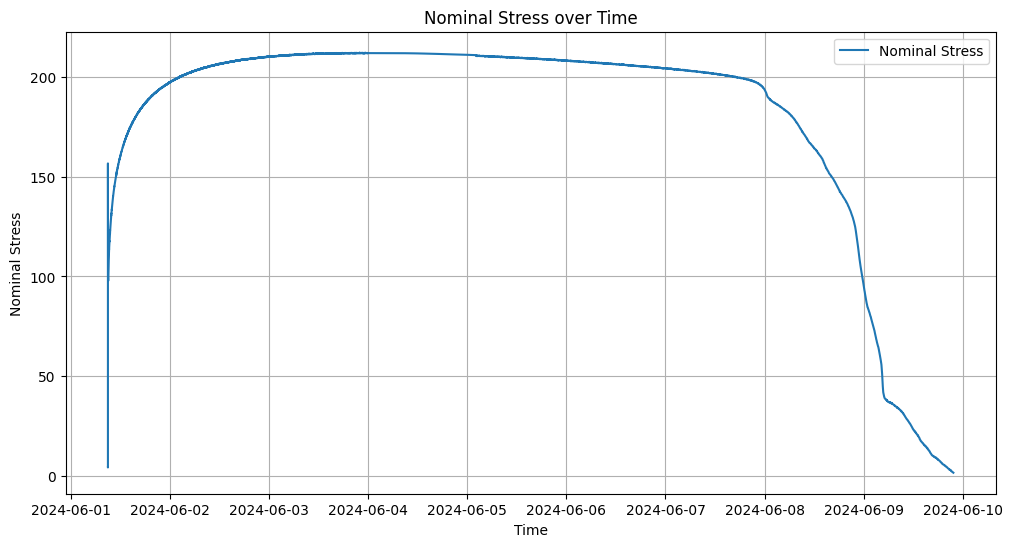

In [ ]:
from google.colab import drive
import pandas as pd

# Googleドライブをマウント
drive.mount('/content/drive')

# データをGoogleドライブから読み込み
data_path = '/content/drive/MyDrive/Excel_to_CSV/F.csv'
df = pd.read_csv(data_path)

# 必要な列のみ抽出（暇のため適切な列を選択）
# 必要に応じて 'parse_dates' を使用して日時データを適切に解析
df = df[['time', 'Nominal strain', 'Nominal stress']]

# 'time'列を日時として解析し、インデックスに設定
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# データフレームの表示
print(df.head())

# 悪液確認かつ興味予備解析用プロット
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Nominal stress'], label='Nominal Stress')
plt.xlabel('Time')
plt.ylabel('Nominal Stress')
plt.title('Nominal Stress over Time')
plt.legend()
plt.grid(True)
plt.show()

from google.colab import drive
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Googleドライブをマウント
drive.mount('/content/drive')

# データをGoogleドライブから読み込み
data_path = '/content/drive/MyDrive/Excel_to_CSV/F-P.csv'
df = pd.read_csv(data_path)

# 必要な列のみ抽出（暇のため適切な列を選択）
# 必要に応じて 'parse_dates' を使用して日時データを適切に解析
df = df[['time', 'Nominal strain', 'Nominal stress']]

# 'time'列を日時として解析し、インデックスに設定
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

def augment_stress_increase(df, increase_value=0.1):
    """Nominal stress の値を微増加させる"""
    df_augmented = df.copy()
    df_augmented['Nominal stress'] += increase_value
    return df_augmented

def augment_stress_decrease(df, decrease_value=0.1):
    """Nominal stress の値を一定量減少させる"""
    df_augmented = df.copy()
    df_augmented['Nominal stress'] -= decrease_value
    return df_augmented

def augment_strain(df, strain_std=0.02):
    """Nominal strain の値を微増減する"""
    df_augmented = df.copy()
    df_augmented['Nominal strain'] += np.random.normal(0, strain_std, size=df.shape[0])
    return df_augmented

def augment_time(df, time_factor=0.05):
    """time の時間レンジを微量に短長期化する"""
    df_augmented = df.copy()
    duration = (df.index[-1] - df.index[0]).total_seconds()
    shift = np.random.uniform(-time_factor, time_factor) * duration
    df_augmented.index = df.index + pd.to_timedelta(shift, unit='s')
    return df_augmented

def augment_time_shorter(df, shorten_factor=0.1):
    """終了時間を短期化させる（データを圧縮する）"""
    df_augmented = df.copy()
    # 元の終了時間
    end_time = df.index[-1]
    # データ圧縮による新しい終了時間
    new_end_time = df.index[0] + (end_time - df.index[0]) * (1 - shorten_factor)
    # 新しい時間インデックスの作成
    df_augmented.index = pd.date_range(start=df.index[0], end=new_end_time, periods=len(df))
    return df_augmented

def augment_time_longer(df, extend_factor=0.1):
    """終了時間を長期化させる（データを拡張する）"""
    df_augmented = df.copy()
    # 元の終了時間
    end_time = df.index[-1]
    # データ拡張による新しい終了時間
    new_end_time = df.index[0] + (end_time - df.index[0]) * (1 + extend_factor)
    # 新しい時間インデックスの作成
    df_augmented.index = pd.date_range(start=df.index[0], end=new_end_time, periods=len(df))
    return df_augmented

def add_noise(df, noise_level=0.01):
    """波形形状が変わらない程度のノイズを与える"""
    df_noised = df.copy()
    df_noised['Nominal stress'] += np.random.normal(0, noise_level, size=df.shape[0])
    return df_noised


# データ拡張の実行
df_stress_increase_augmented  = augment_stress_increase(df, increase_value=20)
df_stress_decrease_augmented = augment_stress_decrease(df, decrease_value=20)
df_strain_augmented = augment_strain(df, strain_std=0.0001)
df_time_augmented = augment_time(df, time_factor=0.1)
df_time_shortened = augment_time_shorter(df, shorten_factor=0.1)
df_time_longer = augment_time_longer(df, extend_factor=0.1)
df_noised = add_noise(df, noise_level=2)

# 拡張結果のプロット
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Nominal stress'], label='Original', color='b')
plt.plot(df_stress_increase_augmented.index, df_stress_increase_augmented['Nominal stress'], label='Stress Augmented INC', linestyle='--')
plt.plot(df_stress_decrease_augmented.index, df_stress_decrease_augmented['Nominal stress'], label='Stress Augmented DEC', linestyle='--')
plt.plot(df_strain_augmented.index, df_strain_augmented['Nominal stress'], label='Strain Augmented', linestyle='--')
plt.plot(df_time_augmented.index, df_time_augmented['Nominal stress'], label='Time Augmented', linestyle='--')
plt.plot(df_time_shortened.index, df_time_augmented['Nominal stress'], label='Time Shortened', linestyle='--')
plt.plot(df_time_longer.index, df_time_augmented['Nominal stress'], label='Time Lengthened', linestyle='--')
plt.plot(df_noised.index, df_noised['Nominal stress'], label='Noised', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Nominal Stress')
plt.legend()
plt.show()

# csv保存
df_stress_increase_augmented.to_csv('F-P_stress_increase_augmented20.csv')
df_stress_decrease_augmented.to_csv('F-P_stress_decrease_augmented20.csv')
df_strain_augmented.to_csv('F-P_strain_augmented00001.csv')
df_time_augmented.to_csv('F-P_time_augmented0.1.csv')
df_time_shortened.to_csv('F-P_time_shortened0.1.csv')
df_time_augmented.to_csv('F-P_time_Lengthened0.1.csv')
df_noised.to_csv('F-P_noised2.csv')

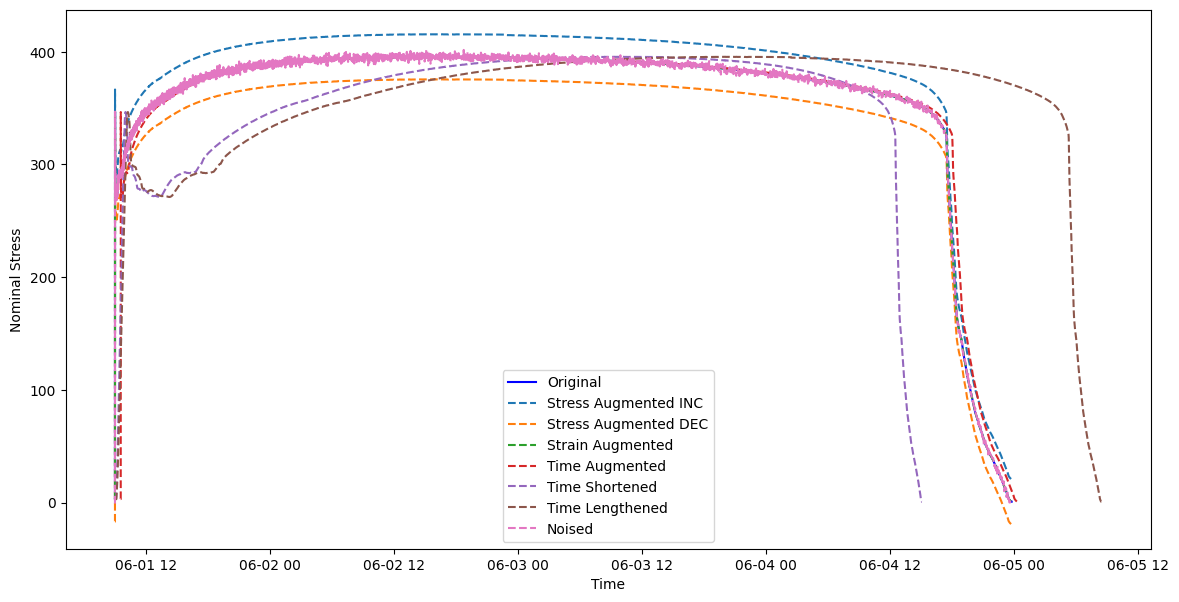

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def augment_stress_increase(df, increase_value=0.1):
    """Nominal stress の値を微増加させる"""
    df_augmented = df.copy()
    df_augmented['Nominal stress'] += increase_value
    return df_augmented

def augment_stress_decrease(df, decrease_value=0.1):
    """Nominal stress の値を一定量減少させる"""
    df_augmented = df.copy()
    df_augmented['Nominal stress'] -= decrease_value
    return df_augmented

def augment_strain(df, strain_std=0.02):
    """Nominal strain の値を微増減する"""
    df_augmented = df.copy()
    df_augmented['Nominal strain'] += np.random.normal(0, strain_std, size=df.shape[0])
    return df_augmented

def augment_time(df, time_factor=0.05):
    """time の時間レンジを微量に短長期化する"""
    df_augmented = df.copy()
    duration = (df.index[-1] - df.index[0]).total_seconds()
    shift = np.random.uniform(-time_factor, time_factor) * duration
    df_augmented.index = df.index + pd.to_timedelta(shift, unit='s')
    return df_augmented

def augment_time_shorter(df, shorten_factor=0.1):
    """終了時間を短期化させる（データを圧縮する）"""
    df_augmented = df.copy()
    # 元の終了時間
    end_time = df.index[-1]
    # データ圧縮による新しい終了時間
    new_end_time = df.index[0] + (end_time - df.index[0]) * (1 - shorten_factor)
    # 新しい時間インデックスの作成
    df_augmented.index = pd.date_range(start=df.index[0], end=new_end_time, periods=len(df))
    return df_augmented

def augment_time_longer(df, extend_factor=0.1):
    """終了時間を長期化させる（データを拡張する）"""
    df_augmented = df.copy()
    # 元の終了時間
    end_time = df.index[-1]
    # データ拡張による新しい終了時間
    new_end_time = df.index[0] + (end_time - df.index[0]) * (1 + extend_factor)
    # 新しい時間インデックスの作成
    df_augmented.index = pd.date_range(start=df.index[0], end=new_end_time, periods=len(df))
    return df_augmented

def add_noise(df, noise_level=0.01):
    """波形形状が変わらない程度のノイズを与える"""
    df_noised = df.copy()
    df_noised['Nominal stress'] += np.random.normal(0, noise_level, size=df.shape[0])
    return df_noised


# データ拡張の実行
df_stress_increase_augmented  = augment_stress_increase(df, increase_value=20)
df_stress_decrease_augmented = augment_stress_decrease(df, decrease_value=20)
df_strain_augmented = augment_strain(df, strain_std=0.0001)
df_time_augmented = augment_time(df, time_factor=0.1)
df_time_shortened = augment_time_shorter(df, shorten_factor=0.1)
df_time_longer = augment_time_longer(df, extend_factor=0.1)
df_noised = add_noise(df, noise_level=2)

# 拡張結果のプロット
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Nominal stress'], label='Original', color='b')
plt.plot(df_stress_increase_augmented.index, df_stress_increase_augmented['Nominal stress'], label='Stress Augmented INC', linestyle='--')
plt.plot(df_stress_decrease_augmented.index, df_stress_decrease_augmented['Nominal stress'], label='Stress Augmented DEC', linestyle='--')
plt.plot(df_strain_augmented.index, df_strain_augmented['Nominal stress'], label='Strain Augmented', linestyle='--')
plt.plot(df_time_augmented.index, df_time_augmented['Nominal stress'], label='Time Augmented', linestyle='--')
plt.plot(df_time_shortened.index, df_time_augmented['Nominal stress'], label='Time Shortened', linestyle='--')
plt.plot(df_time_longer.index, df_time_augmented['Nominal stress'], label='Time Lengthened', linestyle='--')
plt.plot(df_noised.index, df_noised['Nominal stress'], label='Noised', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Nominal Stress')
plt.legend()
plt.show()

# csv保存
df_stress_increase_augmented.to_csv('F_stress_increase_augmented20.csv')
df_stress_decrease_augmented.to_csv('F_stress_decrease_augmented20.csv')
df_strain_augmented.to_csv('F_strain_augmented00001.csv')
df_time_augmented.to_csv('F_time_augmented0.1.csv')
df_time_shortened.to_csv('F_time_shortened0.1.csv')
df_time_augmented.to_csv('F_time_Lengthened0.1.csv')
df_noised.to_csv('F_noised2.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


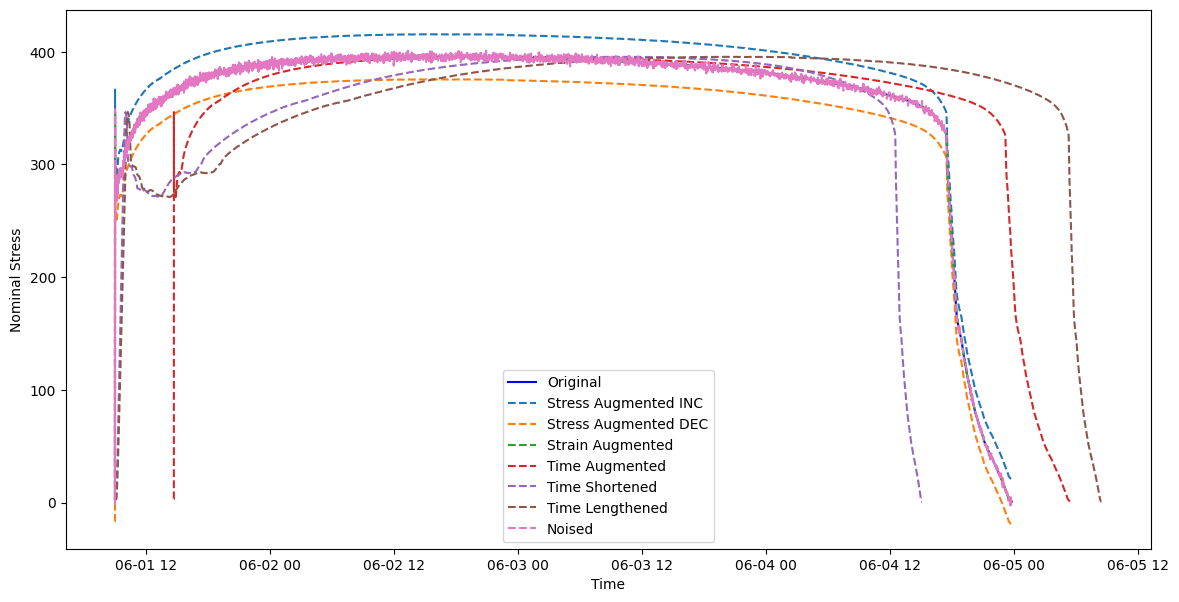

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Googleドライブをマウント
drive.mount('/content/drive')

# データをGoogleドライブから読み込み
data_path = '/content/drive/MyDrive/Excel_to_CSV/filename.csv'
df = pd.read_csv(data_path)

# 必要な列のみ抽出
# 必要に応じて 'parse_dates' を使用して日時データを適切に解析
df = df[['time', 'Nominal strain', 'Nominal stress']]

# 'time'列を日時として解析し、インデックスに設定
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

def augment_stress_increase(df, increase_value=0.1):
    """Nominal stress の値を微増加させる"""
    df_augmented = df.copy()
    df_augmented['Nominal stress'] += increase_value
    return df_augmented

def augment_stress_decrease(df, decrease_value=0.1):
    """Nominal stress の値を一定量減少させる"""
    df_augmented = df.copy()
    df_augmented['Nominal stress'] -= decrease_value
    return df_augmented

def augment_strain(df, strain_std=0.02):
    """Nominal strain の値を微増減する"""
    df_augmented = df.copy()
    df_augmented['Nominal strain'] += np.random.normal(0, strain_std, size=df.shape[0])
    return df_augmented

def augment_time(df, time_factor=0.05):
    """time の時間レンジを微量に短長期化する"""
    df_augmented = df.copy()
    duration = (df.index[-1] - df.index[0]).total_seconds()
    shift = np.random.uniform(-time_factor, time_factor) * duration
    df_augmented.index = df.index + pd.to_timedelta(shift, unit='s')
    return df_augmented

def augment_time_longer(df, extend_factor=0.1):
    """終了時間を長期化させる（データを拡張する）"""
    df_augmented = df.copy()
    # 元の終了時間
    end_time = df.index[-1]
    # データ拡張による新しい終了時間
    new_end_time = df.index[0] + (end_time - df.index[0]) * (1 + extend_factor)
    # 新しい時間インデックスの作成
    df_augmented.index = pd.date_range(start=df.index[0], end=new_end_time, periods=len(df))
    return df_augmented

def add_noise(df, noise_level=0.01):
    """波形形状が変わらない程度のノイズを与える"""
    df_noised = df.copy()
    df_noised['Nominal stress'] += np.random.normal(0, noise_level, size=df.shape[0])
    return df_noised

#具体的な程度は以下で指定
# データ拡張の実行
df_stress_increase_augmented  = augment_stress_increase(df, increase_value=20)#一律に-20
df_stress_decrease_augmented = augment_stress_decrease(df, decrease_value=20)#一律に＋20
df_strain_augmented = augment_strain(df, strain_std=0.0001)#平均0，標準偏差0.0001のノイズ
df_time_augmented = augment_time(df, time_factor=0.1)#0.1=10%
df_time_shortened = augment_time_shorter(df, shorten_factor=0.1)#0.1=10%
df_time_longer = augment_time_longer(df, extend_factor=0.1)#0.1=10%
df_noised = add_noise(df, noise_level=2)#平均0，標準偏差2のノイズ

# 拡張結果のプロット
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Nominal stress'], label='Original', color='b')
plt.plot(df_stress_increase_augmented.index, df_stress_increase_augmented['Nominal stress'], label='Stress Augmented INC', linestyle='--')
plt.plot(df_stress_decrease_augmented.index, df_stress_decrease_augmented['Nominal stress'], label='Stress Augmented DEC', linestyle='--')
plt.plot(df_strain_augmented.index, df_strain_augmented['Nominal stress'], label='Strain Augmented', linestyle='--')
plt.plot(df_time_augmented.index, df_time_augmented['Nominal stress'], label='Time Augmented', linestyle='--')
plt.plot(df_time_longer.index, df_time_augmented['Nominal stress'], label='Time Lengthened', linestyle='--')
plt.plot(df_noised.index, df_noised['Nominal stress'], label='Noised', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Nominal Stress')
plt.legend()
plt.show()

# csv保存
#df_stress_increase_augmented.to_csv('_stress_increase_augmented20.csv')
#df_stress_decrease_augmented.to_csv('_stress_decrease_augmented20.csv')
#df_strain_augmented.to_csv('_strain_augmented00001.csv')
#df_time_augmented.to_csv('_time_augmented0.1.csv')
#df_time_augmented.to_csv('_time_Lengthened0.1.csv')
#df_noised.to_csv('_noised2.csv')